In [17]:
import pennylane as qml
import jax
from jax import numpy as jnp
import optax
import numpy as np
import matplotlib.pyplot as plt

In [18]:
#Setting 64-bit precision as default type
jax.config.update("jax_enable_x64",True)

In [19]:
def generate_knot_vector_uniform(grid_points, control_points, degree):
    
    """
    Function : Generates uniform knot vector
    
    Parameters:
    grid_points (int): length of the knot vector
    control_points (array): array of control points for the knot vector
    degree (int): degree of B-Spline function
    
    Returns:
    array : Uniform Knot Vector with points between 0 and 2
    """
    
    min_grid_points = degree + len(control_points) + 1
    if grid_points < min_grid_points:
        raise ValueError(f"Number of grid points must be at least {min_grid_points}")
    knots = np.linspace(0, 60, grid_points)
    return knots


def cox_de_boor(x, i, degree, t):
    
    """
    Function : Recursive Cox De-Boor Algorithm for the basis of B-Spline
    
    Parameters:
        x (int): a knot vector point where basis (N_{i,j}(t)) is to be calculated
        i (int): a control point where basis (N_{i,j}) is to be calculated
        degree (int): degree of B-Spline function (j in N_{i,j})
        t (array): uniform knot vector
    
    Returns:
        array : Basis functions (N_{i,j}(t)) for B-Spline function
    """
    
    if degree == 0:
        return np.where((t[i] <= x) & (x < t[i+1]), np.array(1.0,dtype=np.float32), np.array(0.0,dtype=np.float32))
    else:
        j = degree
        coeff1 = (x - t[i])/(t[i+j] - t[i]) if (t[i+j] != t[i]) else np.array(0.0,dtype=np.float32)
        coeff2 = (t[i+j+1] - x)/(t[i+j+1] - t[i+1]) if (t[i+j+1] != t[i+1]) else np.array(0.0,dtype=np.float32)
        
        return coeff1 * cox_de_boor(x,i,degree-1,t) + coeff2 * cox_de_boor(x,i+1,degree-1,t)

def bspline(x,control_points,degree,knots):
   return sum(control_points[i] * cox_de_boor(x,i,degree,knots) for i in range(len(control_points))) 


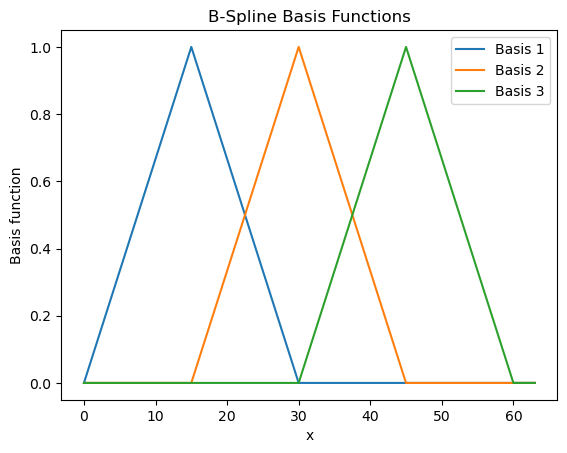

In [20]:
# Assuming the rest of your code is correct and imported
degree = 1
control_points = np.ones(3)  # Simple control points (all ones)
num_knots = 5

#Should satisfy control_points = (num_knots - degree - 1) = (num_knots - 2)

knots = generate_knot_vector_uniform(num_knots, control_points, degree)

# Plotting
n_qubits = 6
x_max = 2**n_qubits
x_input = np.arange(x_max)  # Fine x grid for smooth curves

#Taking (no of control_points = no of x inputs)

combined_distribution = []
for i in range(len(control_points)):
    y_values = np.array([cox_de_boor(x, i, degree, knots) for x in x_input])
    plt.plot(x_input, y_values, label=f'Basis {i+1}')
    combined_distribution.append(y_values)
    
combined_distribution = np.max(combined_distribution,axis=0)

plt.title('B-Spline Basis Functions')
plt.xlabel('x')
plt.ylabel('Basis function')
plt.legend()
plt.show()


In [21]:
knots

array([ 0., 15., 30., 45., 60.])

In [22]:
x_input

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63])

In [23]:
combined_distribution

array([0.        , 0.06666667, 0.13333333, 0.2       , 0.26666667,
       0.33333333, 0.4       , 0.46666667, 0.53333333, 0.6       ,
       0.66666667, 0.73333333, 0.8       , 0.86666667, 0.93333333,
       1.        , 0.93333333, 0.86666667, 0.8       , 0.73333333,
       0.66666667, 0.6       , 0.53333333, 0.53333333, 0.6       ,
       0.66666667, 0.73333333, 0.8       , 0.86666667, 0.93333333,
       1.        , 0.93333333, 0.86666667, 0.8       , 0.73333333,
       0.66666667, 0.6       , 0.53333333, 0.53333333, 0.6       ,
       0.66666667, 0.73333333, 0.8       , 0.86666667, 0.93333333,
       1.        , 0.93333333, 0.86666667, 0.8       , 0.73333333,
       0.66666667, 0.6       , 0.53333333, 0.46666667, 0.4       ,
       0.33333333, 0.26666667, 0.2       , 0.13333333, 0.06666667,
       0.        , 0.        , 0.        , 0.        ])

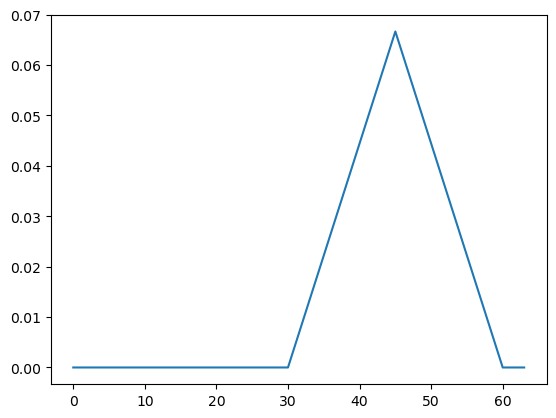

In [24]:
from scipy.integrate import trapezoid  # For numerical integration
area = trapezoid(y_values,x_input)

normalized_y = y_values/ area
plt.plot(x_input,normalized_y)

In [25]:
bspline_func = bspline(x_input,control_points,degree,knots)
# plt.plot(x_input,bspline_func)

## Loss and QCBM Functions

In [26]:
#Defining squared maximum mean discrepancy (MMD) Loss function for Radial basis function (RBF) kernel
class MMD:
    
    def __init__(self, scales, space):
        #scales = list of guassian width (sigma)
        #space = data points x and y
        
        gammas = 1 / (2*(scales**2)).reshape(-1, 1, 1)  # Reshape gammas to (2, 1, 1)
        sq_dists = jnp.abs(space[:,None] - space[None,:])**2
        self.K = jnp.sum(jnp.exp(-gammas * sq_dists), axis=0) / len(scales)
        self.scales = scales
        
    def k_expval(self,px,py):
        return px @ self.K @ py
    
    def __call__(self,px,py):
        pxy = px-py
        return self.k_expval(pxy,pxy)

In [27]:
#defining class QCBM that holds qcbm and objective function that has to be minimized
from functools import partial

class QCBM:
    
    def __init__(self, circ, mmd, py):
        self.circ = circ    #qcbm circuit
        self.mmd = mmd      #loss obtained
        self.py = py        #target distribution pi(x)
        
    @partial(jax.jit, static_argnums=0)
    def mmd_loss(self,params):
        px = self.circ(params) #obtained distribution p(x)
        print("Obtained distribution (px):",px)
        return self.mmd(px,self.py), px

### QCBM for Bspline basis function for 1 control point and degree 1

In [28]:
data = normalized_y

Initial circuit probabilities: [1.83969624e-01 2.21447679e-02 5.28310466e-03 7.66143735e-03
 2.54853679e-02 5.21287821e-03 8.61892420e-03 2.80747877e-02
 2.12290467e-02 3.18336246e-03 1.06758845e-02 3.45947738e-03
 2.65161981e-03 1.17198151e-03 2.58479538e-03 3.01767207e-02
 7.65594550e-03 1.91917889e-02 1.76587814e-03 1.44455205e-03
 8.71837758e-04 6.38159475e-03 1.04968348e-02 8.24016393e-03
 4.65252397e-04 1.52351617e-04 5.58179747e-03 1.78896653e-02
 3.90722554e-04 1.75469385e-02 5.83762484e-03 2.59994729e-02
 5.51713163e-03 1.29407049e-02 2.20117061e-02 2.17101447e-02
 2.32276242e-03 8.80652940e-03 6.71487901e-03 2.20067317e-02
 1.44255011e-02 1.18830482e-02 3.61214566e-02 7.05544788e-03
 3.85018446e-02 1.58853104e-02 6.32289164e-03 2.41914705e-03
 1.92038764e-02 2.31530518e-02 6.98444648e-03 2.41429526e-02
 6.38073833e-03 3.77763868e-02 1.43168973e-02 2.00660856e-03
 1.25559108e-02 9.70505181e-03 4.55078345e-03 1.64957356e-03
 1.36997759e-02 3.58454866e-02 5.18596742e-02 1.002734

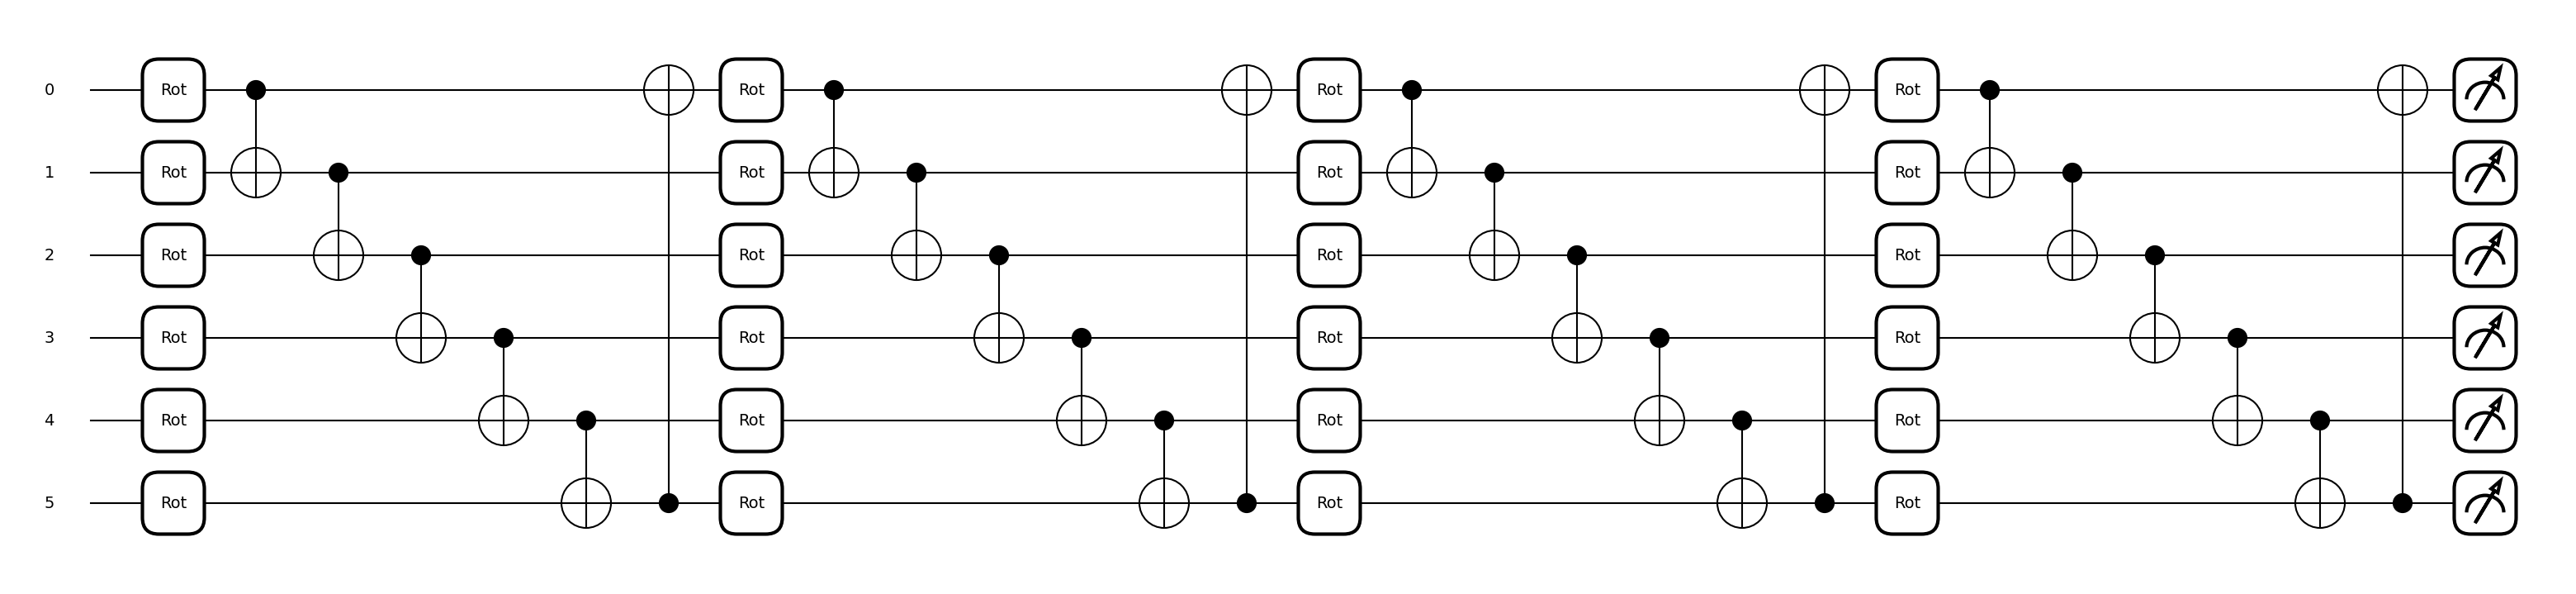

In [29]:
#Defining an ansatz quantum circuit to be used for qcbm

dev = qml.device("default.qubit", wires=n_qubits)

n_layers = 4
wshape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_qubits)
weights = np.random.random(size=wshape)

@qml.qnode(dev)
def circuit(weights):
    qml.StronglyEntanglingLayers(weights=weights,wires=range(n_qubits),ranges=[1]*n_layers)
    return qml.probs()

jit_circuit = jax.jit(circuit)
print("Initial circuit probabilities:", circuit(weights))

qml.draw_mpl(circuit, level="device")(weights)
plt.show()

In [30]:
#Training

@jax.jit
def update_step(params, opt_state):

    (loss_val, qcbm_probs), grads = jax.value_and_grad(qcbm.mmd_loss, has_aux=True)(params)

    #grads = jnp.clip(grads,1e-8,None)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    #params = jnp.clip(params,1e-8,None)
    kl_div = -jnp.sum(qcbm.py * jnp.nan_to_num(jnp.log(qcbm_probs / qcbm.py)))
    return params, opt_state, loss_val, kl_div

In [33]:
#Lets optimize the above circuit with sqaured MMD loss function

bandwidth = jnp.array([0.25,16])
space = jnp.arange(2**n_qubits)

mmd = MMD(bandwidth,space=space)
qcbm = QCBM(jit_circuit,mmd,data)

opt = optax.adam(learning_rate=0.1)
opt_state = opt.init(weights)

history = []
divs = []
n_iterations = 200
#print(weights)
for i in range(n_iterations):
    weights, opt_state, loss_val, kl_div = update_step(weights, opt_state)

    if i%10 == 0:
        print(f"Step: {i} Loss: {loss_val} KL_div:{kl_div}")
        #print(weights)
    
    history.append(loss_val)
    divs.append(kl_div)

Step: 0 Loss: 0.0008072564479414875 KL_div:0.07400996589675521
Step: 10 Loss: 0.001134605471236934 KL_div:0.0882858041378775
Step: 20 Loss: 0.0004440885832237876 KL_div:0.05404839691257959
Step: 30 Loss: 0.0002865810504666687 KL_div:0.038745761591020104
Step: 40 Loss: 0.0001584602821228975 KL_div:0.028845924789461772
Step: 50 Loss: 7.700603269617525e-05 KL_div:0.014942360938633596
Step: 60 Loss: 6.100535161058285e-05 KL_div:0.014331034776676944
Step: 70 Loss: 5.479890755653333e-05 KL_div:0.013184784628992838
Step: 80 Loss: 4.9783521678391967e-05 KL_div:0.012072613697317922
Step: 90 Loss: 4.616876787470089e-05 KL_div:0.010776805356323067
Step: 100 Loss: 4.379150532529974e-05 KL_div:0.010196938666365209
Step: 110 Loss: 4.187937413758095e-05 KL_div:0.009675754592405475
Step: 120 Loss: 4.004091677882127e-05 KL_div:0.009333021738387647
Step: 130 Loss: 3.8156493337720866e-05 KL_div:0.009056778679104632
Step: 140 Loss: 3.608302767825528e-05 KL_div:0.008766292108887007
Step: 150 Loss: 3.368130

<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_832/2824532080.py:3: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(range(x_max),data,linestyle='-',label='$\pi(x)$')


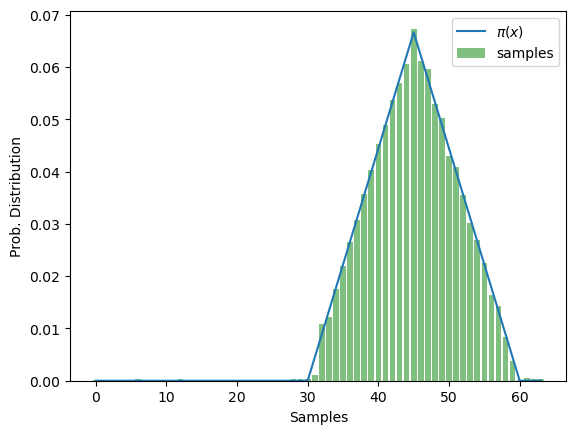

In [34]:
qcbm_probs = qcbm.circ(weights)

plt.plot(range(x_max),data,linestyle='-',label='$\pi(x)$')
plt.bar(range(x_max),qcbm_probs,color='green',alpha=0.5,label='samples')

plt.xlabel("Samples")
plt.ylabel("Prob. Distribution")

plt.legend()
plt.show()